In [1]:
import sys
sys.path.append('../../')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imutils
import glob
import cv2  # importing cv
import find_peak
import scipy.special as special
from matplotlib import ticker
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
import nfft
import scipy
import scipy.fft
import functions_analysis as fa
from skimage import img_as_float
from skimage import filters

%matplotlib inline 


# scan_number = ['r471', 'r475', 'r470']
# scan_name = [r'0.8 mJ/cm$^2$', r'1.27 mJ/cm$^2$', r'1.6 mJ/cm$^2$']

scan_number = ['r464', 'r471']
scan_name = ['800nm', '400nm']

path_main =r'C:\Users\rclaude\Documents\projet\graphite\drawing\UED_fig'
path=[]
df_list = []
imgON=[]
imgOFF=[]
delay=[]
# path_upload = path_main+r'\comparison\same_fluence_substraction'
for scan in scan_number:
    path.append(path_main + '\\' + scan + r'\data\PROC_filtered_'+scan)
    df = pd.read_pickle(path_main  + r'\data\PROC_'+scan, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})
    imgOFF.append(np.stack(df['imgOFF']))
    imgON.append(np.stack(df['imgON']))
    delay.append(np.stack(df['delay']))
    df_list.append(df)

print(delay)


[array([-2.39976, -1.73316, -1.39986, -1.06656, -0.79992, -0.53328,
       -0.26664,  0.     ,  0.26664,  0.53328,  0.79992,  1.06656,
        1.3332 ,  1.59984,  1.86648,  2.13312,  2.39976,  2.6664 ,
        2.93304,  3.19968,  3.46632,  3.73296,  3.9996 ,  4.6662 ,
        5.3328 ,  5.9994 ,  6.666  ,  7.3326 ,  7.9992 ,  8.26584,
        8.6658 ,  8.93244]), array([-2.39976, -1.73316, -1.39986, -1.06656, -0.79992, -0.53328,
       -0.26664,  0.     ,  0.26664,  0.53328,  0.79992,  1.06656,
        1.3332 ,  1.59984,  1.86648,  2.13312,  2.39976,  2.6664 ,
        2.93304,  3.19968,  3.46632,  3.73296,  3.9996 ,  4.6662 ,
        5.3328 ,  5.9994 ,  6.666  ,  7.3326 ,  7.9992 ,  8.26584,
        8.6658 ,  8.93244, 12.26544, 15.59844, 22.26444, 28.93044,
       35.59644, 42.26244])]


In [2]:
cc = []
BP_pos = []
BP_name = []
BP_name = ['{100}', '{200}', '{110}']
DS_pos = []
DS_name = [r'$\Gamma \to K$ 1o', r'$\Gamma \to K$ 2o', r'$\Gamma \to M$ 1o', r'$\Gamma \to M$ 2o']
DS_name = [r'$K$', r'$\Gamma \to M$']

Zorder=[]
cal = []
for df in df_list:
    L = df.attrs['peak_dist']
    Zo = df.attrs['Zorder_pos']
    Zorder.append(Zo)
    cal.append(df.attrs['calibration'])
    t0 = df.attrs['t0_index']

# cc = L2/2 * np.exp(1j * np.pi * ( 1./2 * np.arange(5)))## for squared BZ
    cc.append( L * np.sqrt(3)/3 *np.exp(1j * np.pi  * ( 1./3 * np.arange(7)))) ## for hexagonal BZ
    #### construction position of the Bragg peak, ordered by family

    BP_pos.append(fa.bragg_peak_position(Zo, L))

    #### construction position of the K-pont, ordered by family
    DS_pos.append(fa.diffuse_scattering_position2(Zo, L))


before time 0: [-2.39976 -1.73316 -1.39986 -1.06656 -0.79992 -0.53328 -0.26664  0.     ]
after time 0: [0.26664 0.53328 0.79992 1.06656 1.3332  1.59984 1.86648 2.13312 2.39976
 2.6664  2.93304 3.19968 3.46632 3.73296 3.9996  4.6662  5.3328  5.9994
 6.666   7.3326  7.9992  8.26584 8.6658  8.93244]
before time 0: [-2.39976 -1.73316 -1.39986 -1.06656 -0.79992 -0.53328 -0.26664  0.     ]
after time 0: [ 0.26664  0.53328  0.79992  1.06656  1.3332   1.59984  1.86648  2.13312
  2.39976  2.6664   2.93304  3.19968  3.46632  3.73296  3.9996   4.6662
  5.3328   5.9994   6.666    7.3326   7.9992   8.26584  8.6658   8.93244
 12.26544 15.59844 22.26444 28.93044 35.59644 42.26244]


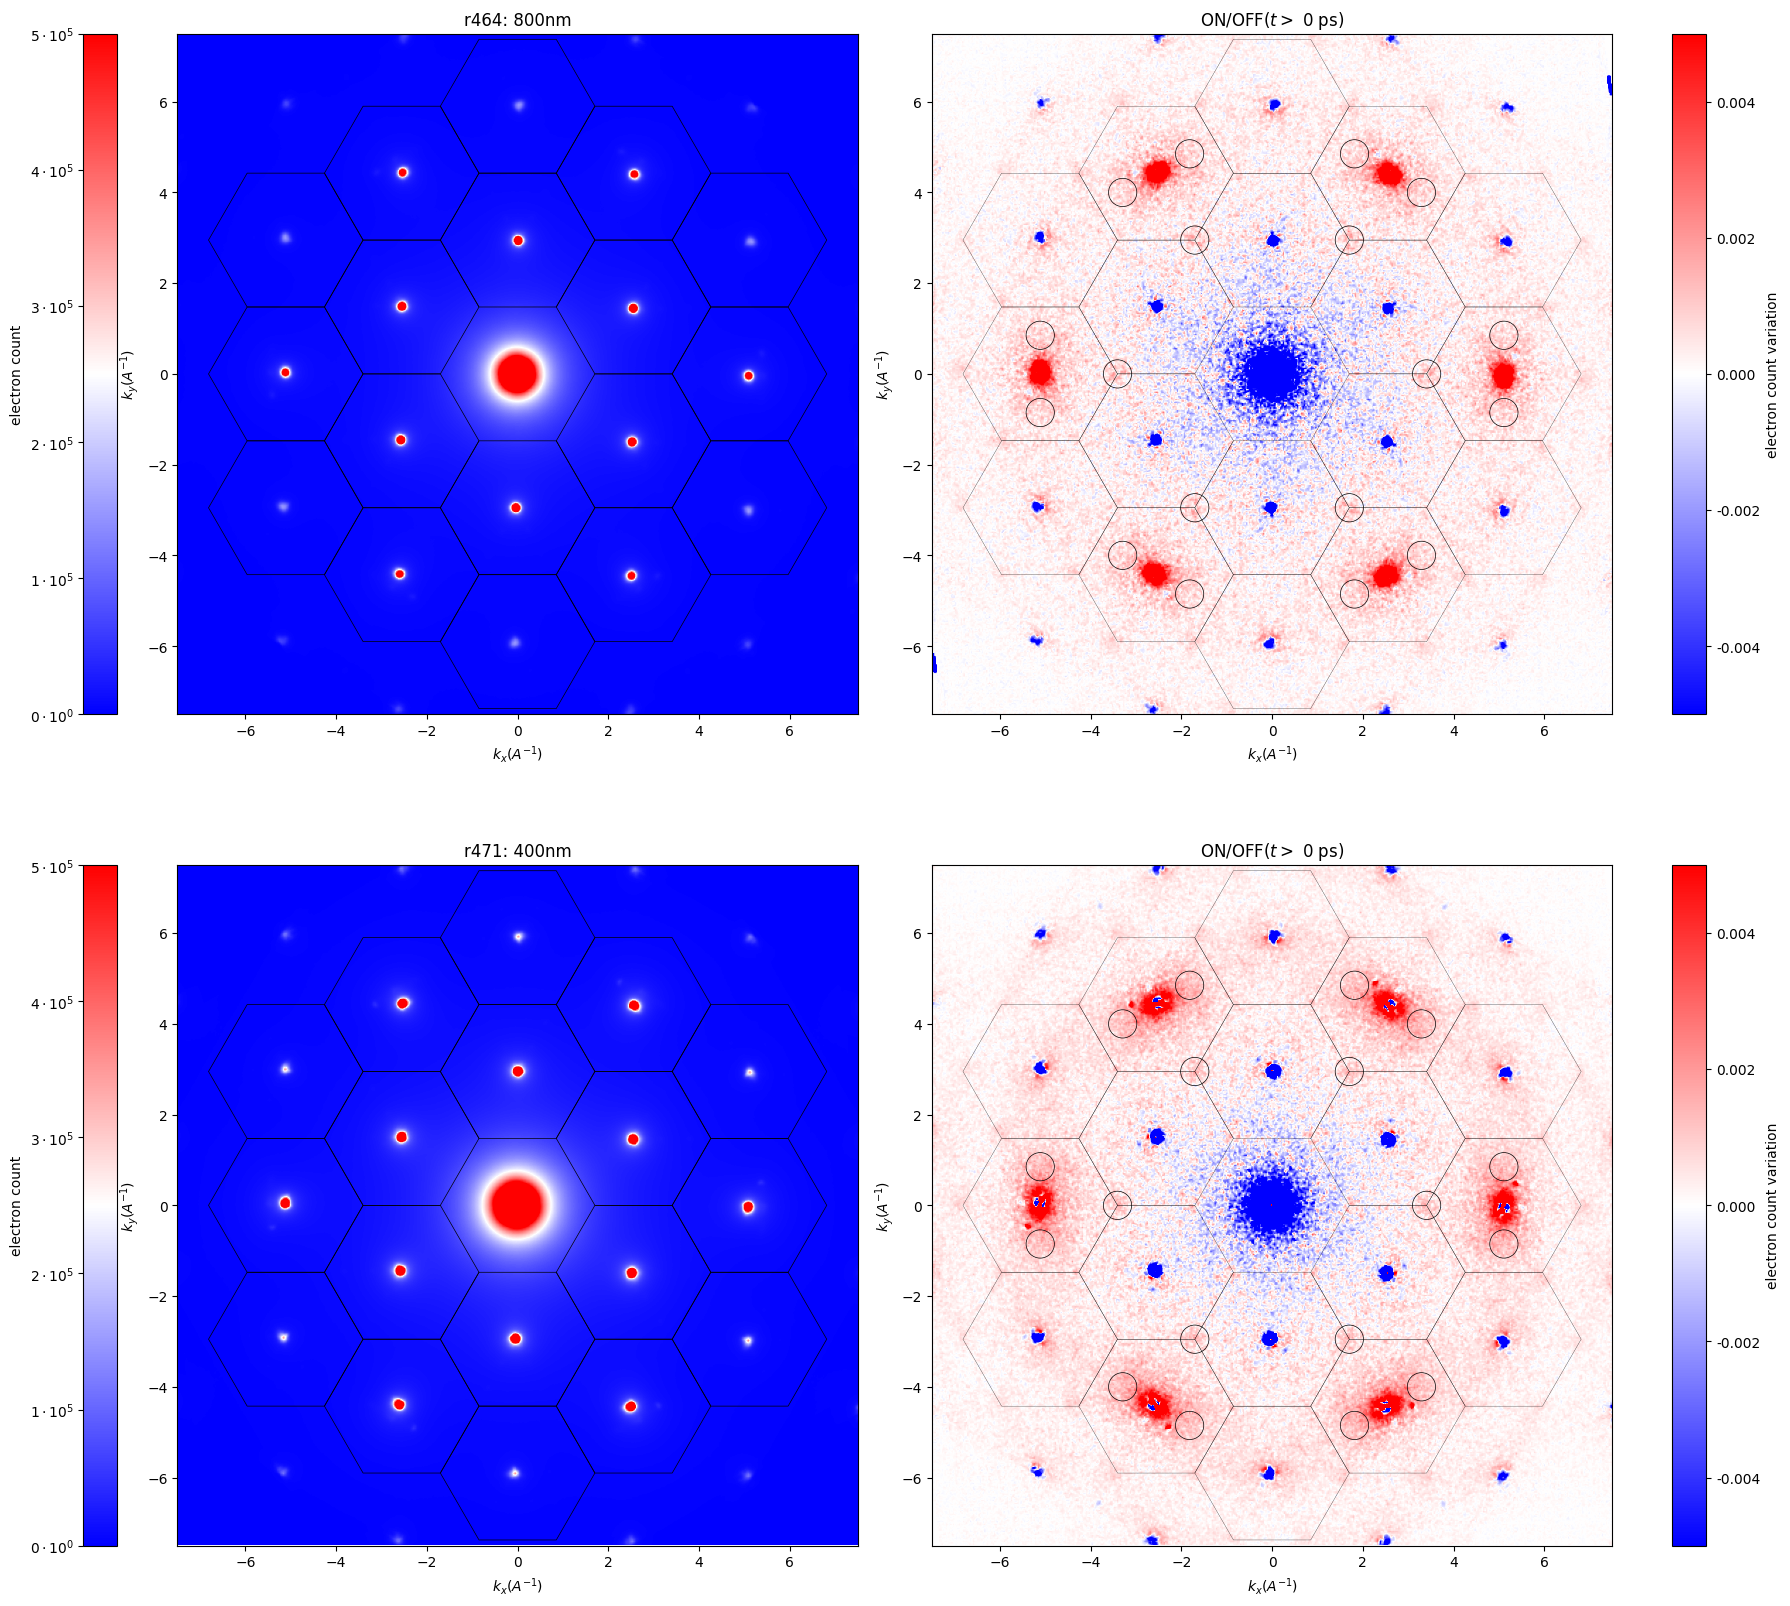

In [3]:
at=t0
bt=t0

lim=7.5
sens = .005
sens2 = 5e5

fig, axis = plt.subplots(len(imgON), 2, figsize=(18, 9*len(imgON)),layout='tight')
for o in range(len(imgON)):
     s1 = np.shape(imgON[o])[2]
     s2 = np.shape(imgON[o])[1]
     print('before time 0:', delay[o][:bt])
     print('after time 0:', delay[o][at:])
     ext = (cal[o]*(Zorder[o][1]), cal[o]*(Zorder[o][1]-s1), cal[o]*(Zorder[o][0]-s2), cal[o]*(Zorder[o][0]))
     # img = (np.nanmean(imgON[o][at:], axis=0))/np.nanmean(imgOFF[o][at:], axis=0) - (np.nanmean(imgON[o][:bt], axis=0))/np.nanmean(imgOFF[o][:bt], axis=0)
     img = (np.mean(imgON[o][at:], axis=0))/np.mean(imgON[o][at:]) - (np.mean(imgON[o][:bt], axis=0))/np.mean(imgON[o][:bt])
     im1= axis[o][0].imshow(imgON[o][0], cmap='bwr',  extent = ext ,vmin=-0, vmax=+sens2, aspect='equal')
     axis[o][0].set_title(scan_number[o] + ': ' + scan_name[o])
     axis[o][0].set_xlabel(r'$k_x (A^{-1})$', fontweight='semibold')
     axis[o][0].set_ylabel(r'$k_y (A^{-1})$')
     axis[o][0].set_xlim(-lim,lim)
     axis[o][0].set_ylim(-lim,lim)

     im2 = axis[o][1].imshow(img, cmap='bwr', extent =ext ,vmin=-sens, vmax=sens, aspect='equal')
     axis[o][1].set_title(r'ON/OFF($t>$ 0 ps)')
     axis[o][1].set_xlabel(r'$k_x (A^{-1})$')
     axis[o][1].set_ylabel(r'$k_y (A^{-1})$')
     axis[o][1].set_xlim(-lim,lim)
     axis[o][1].set_ylim(-lim,lim)

     divider = make_axes_locatable(axis[o][0])
     cax = divider.append_axes('left', size='5%', pad=0.6)        
     fig.colorbar(im1, cax=cax, shrink=0.6, orientation='vertical', label = r'electron count', format=ticker.FuncFormatter(fa.fmt), location='left')

     divider = make_axes_locatable(axis[o][1])
     cax = divider.append_axes('right', size='5%', pad=0.6)        
     fig.colorbar(im2, cax=cax, shrink=0.6, orientation='vertical', label = r'electron count variation', format='%.3f', location='right')
     for i in range(len(BP_pos[o])):
          for j in range(len(BP_pos[o][i])):
               axis[o][0].add_patch(Polygon(cal[o]*np.c_[(cc[o].real+Zorder[o][1]-BP_pos[o][i][j][1]), (cc[o].imag+Zorder[o][0]-BP_pos[o][i][j][0])],
                    lw=0.5, edgecolor='k', clip_on=False, facecolor='none'))
               # axis[j][0].add_patch(Circle((cal*(Zorder[j]-BP_roi[j][i][1]), cal*(Zorder[j]-BP_roi[j][i][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))
               axis[o][1].add_patch(Polygon(cal[o]*np.c_[(cc[o].real+Zorder[o][1]-BP_pos[o][i][j][1]), (cc[o].imag+Zorder[o][0]-BP_pos[o][i][j][0])],
                    lw=0.2, edgecolor='k', clip_on=False, facecolor='none'))
               # axis[1].add_patch(Circle((cal*(Zorder[1]-BP_roi[i][1]), cal*(Zorder[0]-BP_roi[i][0])), 4*cal, fill = False, edgecolor = 'k', lw = 0.5))

     for i in range(len(DS_pos[o])):
          for j in range(len(DS_pos[o][i])):
               axis[o][1].add_patch(Circle((cal[o]*(Zorder[o][1]-DS_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-DS_pos[o][i][j][0])),10*cal[o], fill = False, edgecolor = 'k', lw = 0.5))


In [4]:
for o in range(len(imgON)):
    imgON[o] = filters.gaussian(img_as_float(imgON[o]), sigma=1)
    imgOFF[o] = filters.gaussian(img_as_float(imgOFF[o]), sigma=1)

In [5]:
# plt.rcParams.update({'font.size': 20})
plt.rc('axes', linewidth=2)
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.pad'] = 15
plt.rcParams['ytick.major.pad'] = 15
plt.rcParams['xtick.minor.pad'] = 15
plt.rcParams['ytick.minor.pad'] = 15
plt.rc('axes', linewidth=2)

# plt.rc('font', weight='semibold')
# plt.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'
plt.rc('font', family='arial',size=26)#, weight='bold')
plt.rc('text', usetex=False)

In [6]:
r_BP = 3
r_DS = 10
count_DS = [] 
count_BP = [] 
for o in range(len(imgON)):
    count=[]
    for i in range(len(BP_pos[o])): 
        count.append(fa.get_count(imgON[o], imgOFF[o], BP_pos[o][i], r_BP))
    count_BP.append(count)
    
    count = []
    for i in range(len(DS_pos[o])):
        count.append(fa.get_count(imgON[o], imgOFF[o], DS_pos[o][i], r_DS, False))
    count_DS.append(count)

print(len(count_BP))

no find peak
no find peak
no find peak
no find peak
2


6


C:\Users\rclaude\AppData\Local\Temp\ipykernel_30860\620506619.py:5: RuntimeWarning: invalid value encountered in divide
  img=(np.mean(imgON[o][bt:at], axis=0))/np.mean(imgOFF[o][bt:at], axis=0) - (np.mean(imgON[o][:t0], axis=0))/np.mean(imgOFF[o][:t0], axis=0)


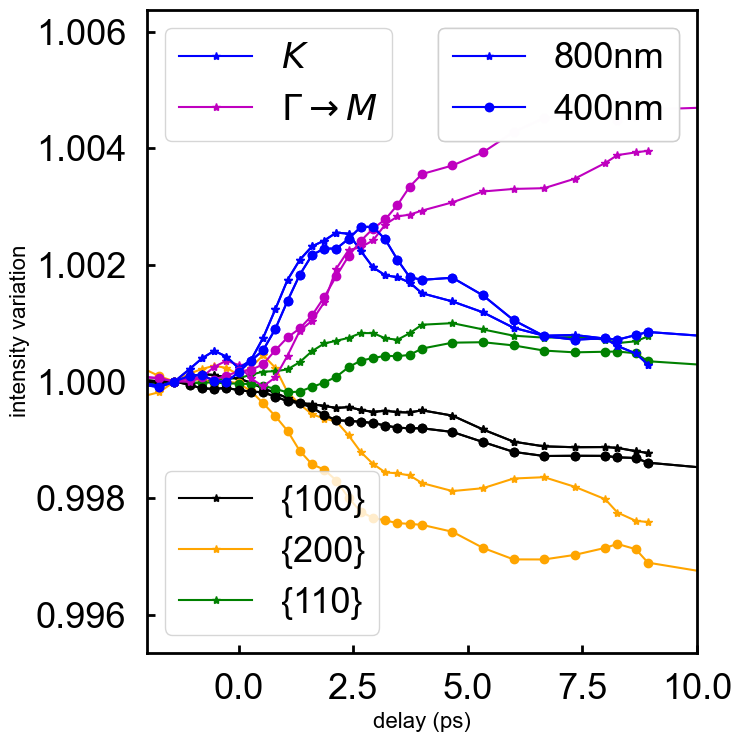

In [7]:
bt = t0+5
at = bt+4
sens = .02
o=0
img=(np.mean(imgON[o][bt:at], axis=0))/np.mean(imgOFF[o][bt:at], axis=0) - (np.mean(imgON[o][:t0], axis=0))/np.mean(imgOFF[o][:t0], axis=0)


fig, axis = plt.subplots(1,1, figsize=(8, 8),layout='tight')

end = len(delay)
c_bp = ['k', 'orange', 'g']
c_ds = ['b', 'm', 'y', 'sienna']
s = ['*-', 'o-', '+-']
leg_bp = []
leg_scan = []
for i in range(len(delay)):
    for j in range(len(count_BP[i])):
        leg_bp.append(axis.plot(delay[i], count_BP[i][j]/count_BP[i][j][2], s[i], c=c_bp[j], label=BP_name[j])[0])
    leg_scan.append(axis.plot(delay[i], count_BP[i][0]/count_BP[i][0][2], s[i], c=c_bp[0], label=scan_number[i])[0])

print(len(leg_bp))
# for i in range(len(count_DS)):
#     axis[0].plot(delay, count_DS[i]/count_DS[i][2], '+-', c=c_ds[i], label=DS_name[i])
# Add first legend:  only labeled data is included
leg1 = axis.legend(leg_bp[:3], BP_name, loc='lower left')
leg2 = axis.legend(leg_scan, scan_name, loc='upper right')

# Manually add the legend 
axis.add_artist(leg1)
axis.add_artist(leg2)

# axis[0].set_title(scan_name)

axis.set_xlabel('delay (ps)', fontsize=16)
axis.set_ylabel(r'intensity variation', fontsize=16)
axis.set_xlim(-2, 10)

leg_ds = []
leg_scan = []
for i in range(len(count_DS)):
    for j in range(len(count_DS[i])):
        leg_ds.append(axis.plot(delay[i], count_DS[i][j]/count_DS[i][j][2], s[i], c=c_ds[j], label=DS_name[j])[0])
    leg_scan.append(axis.plot(delay[i], count_DS[i][0]/count_DS[i][0][2], s[i], c=c_ds[0], label=scan_number[i])[0])

leg1 = axis.legend(leg_ds[:len(count_DS[0])+1], DS_name, loc='upper left')
leg2 = axis.legend(leg_scan, scan_name, loc='upper right')
# Manually add the legend 
axis.add_artist(leg1)
axis.add_artist(leg2)



plt.savefig(r'.\trace_ds.png', format='png', dpi=300)


In [8]:
scan_name = [r'1.55 eV', r'3.1 eV']

In [9]:
print(delay[1][t0])

0.2666399999999943


area around the Bragg peak:  0.012164254663719475
area around the DS point:  0.3041063665929869
6


C:\Users\rclaude\AppData\Local\Temp\ipykernel_30860\3768979065.py:16: RuntimeWarning: invalid value encountered in divide
  img = imgON[o][at]/imgOFF[o][at] - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
C:\Users\rclaude\AppData\Local\Temp\ipykernel_30860\3768979065.py:37: RuntimeWarning: invalid value encountered in divide
  img = imgON[o][at]/imgOFF[o][at] - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)


-1.0665599999999773


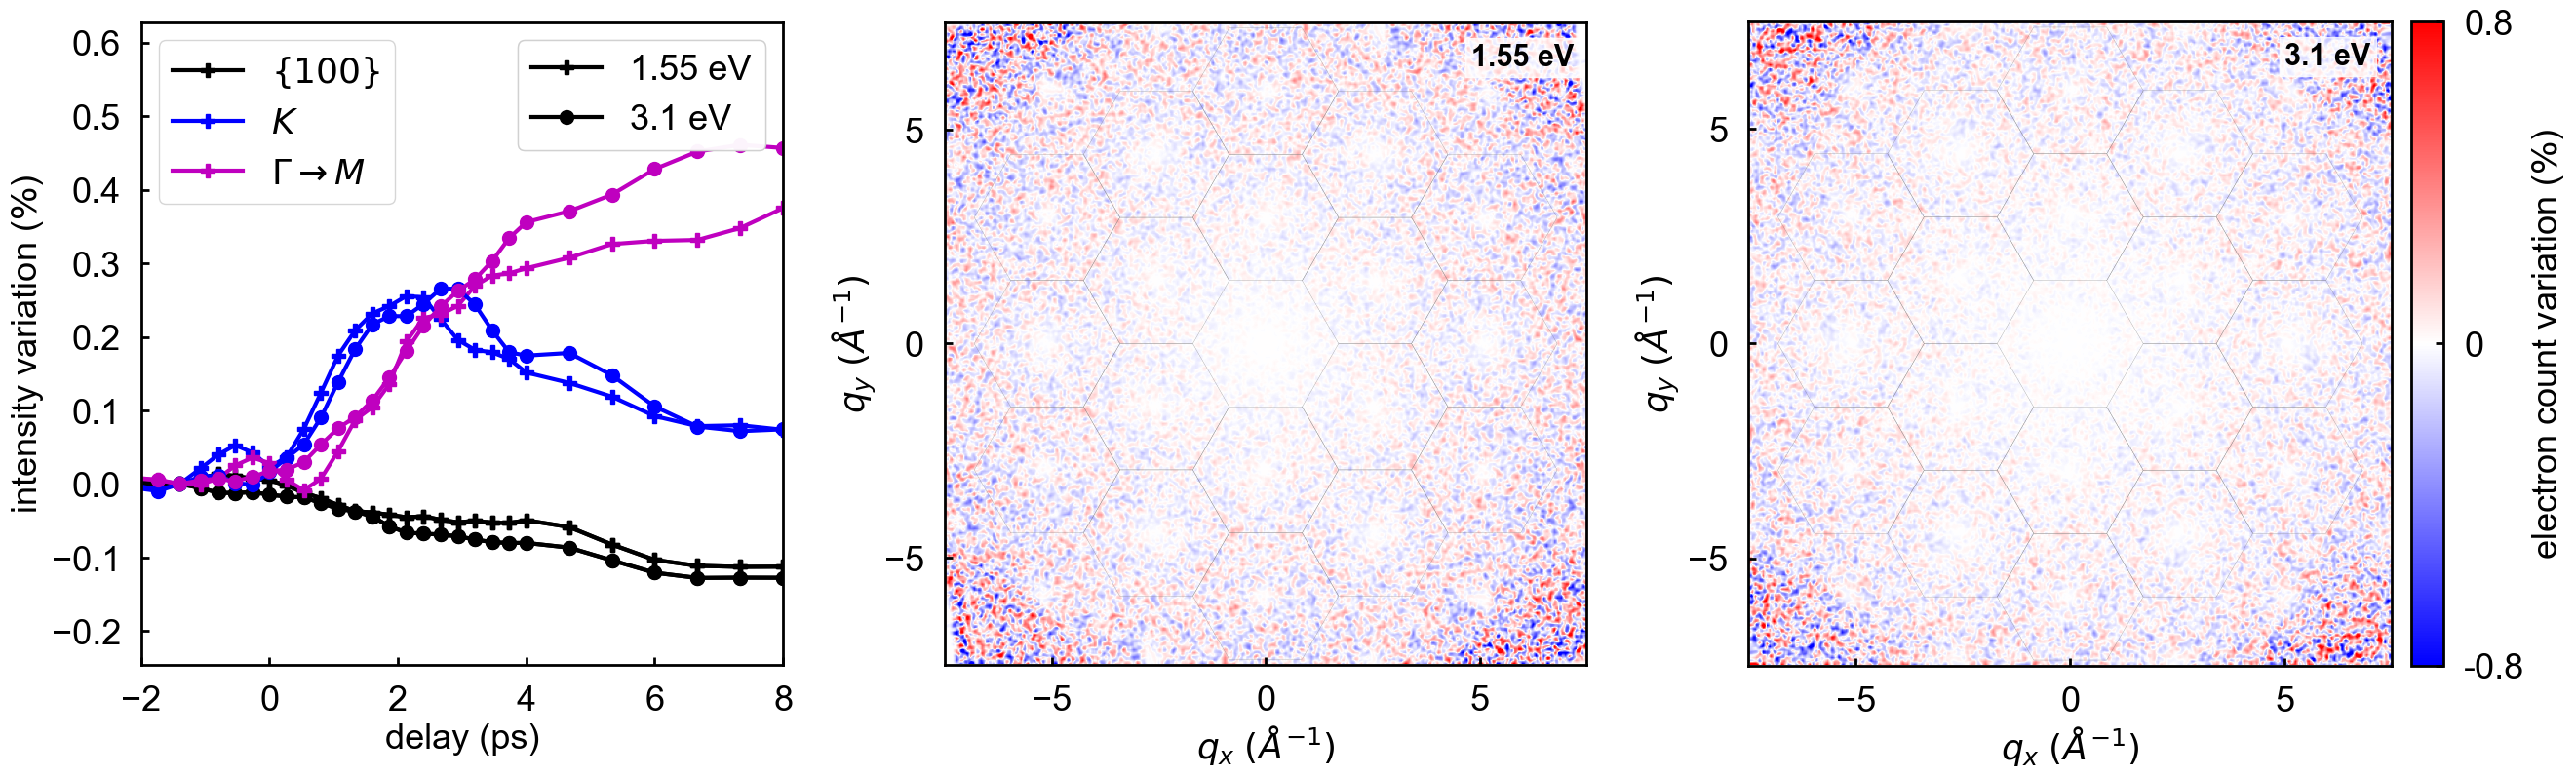

In [15]:
bt = t0
at = bt
sens = .008
lw = 3
ms=10
print('area around the Bragg peak: ', np.pi*(2*cal[0])**2)
print('area around the DS point: ', np.pi*(10*cal[0])**2)
fig, axis = plt.subplots(1,3, figsize=(27, 9), width_ratios=[0.48, 0.48, 0.52], layout='tight')

o=0
# at = (delay[o] > 0.5) & (delay[o] < 2.5)
at = 3
bt = (delay[o] < 0)

# img = (np.nanmean(imgON[o][at], axis=0))/np.nanmean(imgOFF[o][at], axis=0) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
img = imgON[o][at]/imgOFF[o][at] - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)

im1= axis[1].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')
axis[1].set_xlabel(r'$q_x$ $(\AA^{-1})$')
axis[1].set_ylabel(r'$q_y$ $(\AA^{-1})$')
axis[1].set_xlim(-lim,lim)
axis[1].set_ylim(-lim,lim)
axis[1].set_xticks([-5, 0, 5])
axis[1].set_yticks([-5, 0, 5])
# divider = make_axes_locatable(axis[1])
# cax = divider.append_axes('right', size='5%', pad=0.2)        
# fig.colorbar(im1, cax=cax, shrink=0.6, orientation='vertical', label = r'electron count variation ($\%$)',ticks=[-0.008, 0, 0.008], location='right')
# cax.set_yticklabels([-0.8,0,0.8])
t=axis[1].text(4.8, 6.5, scan_name[o], c='k', fontsize = 22, fontweight = 'semibold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

o=1
# at = (delay[o] > 0.5) & (delay[o] < 2.5)
at = 3
bt = (delay[o] < 0)
# img = (np.nanmean(imgON[o][at], axis=0))/np.nanmean(imgOFF[o][at], axis=0) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
img = imgON[o][at]/imgOFF[o][at] - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)

im1= axis[2].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')
axis[2].set_xlabel(r'$q_x$ $(\AA^{-1})$')
axis[2].set_ylabel(r'$q_y$ $(\AA^{-1})$')
axis[2].set_xlim(-lim,lim)
axis[2].set_ylim(-lim,lim)
axis[2].set_xticks([-5, 0, 5])
axis[2].set_yticks([-5, 0, 5])
divider = make_axes_locatable(axis[2])
cax = divider.append_axes('right', size='5%', pad=0.2)        
fig.colorbar(im1, cax=cax, shrink=0.6, orientation='vertical', label = r'electron count variation ($\%$)',ticks=[-0.008, 0, 0.008], location='right')
cax.set_yticklabels([-0.8,0,0.8])
t=axis[2].text(5, 6.5, scan_name[o], c='k', fontsize = 22, fontweight = 'semibold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

c_bp = ['k', 'orange', 'g']
c_ds = ['b', 'm', 'y', 'sienna']
s = ['P-', 'o-', '+-']

for i in range(len(BP_pos[o])):
    for j in range(len(BP_pos[o][i])):
        axis[1].add_patch(Polygon(cal[o]*np.c_[(cc[o].real+Zorder[o][1]-BP_pos[o][i][j][1]), (cc[o].imag+Zorder[o][0]-BP_pos[o][i][j][0])],
               lw=0.2, edgecolor='gray', clip_on=False, facecolor='none'))
        axis[2].add_patch(Polygon(cal[o]*np.c_[(cc[o].real+Zorder[o][1]-BP_pos[o][i][j][1]), (cc[o].imag+Zorder[o][0]-BP_pos[o][i][j][0])],
               lw=0.2, edgecolor='gray', clip_on=False, facecolor='none'))
         
# for i in [0]:
#     for j in range(len(BP_pos[o][i])):
#         axis[1].add_patch(Circle((cal[o]*(Zorder[o][1]-BP_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-BP_pos[o][i][j][0])), 2*cal[o], fill = False, edgecolor = 'k', lw = 2))
#         axis[2].add_patch(Circle((cal[o]*(Zorder[o][1]-BP_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-BP_pos[o][i][j][0])), 2*cal[o], fill = False, edgecolor = 'k', lw = 2))

 
# for i in [0,1]:
#     for j in range(len(DS_pos[o][i])):
#         axis[1].add_patch(Circle((cal[o]*(Zorder[o][1]-DS_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-DS_pos[o][i][j][0])),10*cal[o], fill = False, edgecolor = c_ds[i], lw = 2))
#         axis[2].add_patch(Circle((cal[o]*(Zorder[o][1]-DS_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-DS_pos[o][i][j][0])),10*cal[o], fill = False, edgecolor = c_ds[i], lw = 2))



end = len(delay)
leg_bp = []
leg_scan = []
for i in range(len(count_BP)):
    for j in [0]:
        leg_bp.append(axis[0].plot(delay[i], 1e2*(count_BP[i][j]/count_BP[i][j][2]-1), s[i], lw=lw, c=c_bp[j],markersize=ms, label=BP_name[j])[0])
    leg_scan.append(axis[0].plot(delay[i], 1e2*(count_BP[i][0]/count_BP[i][0][2]-1), s[i], lw=lw,c=c_bp[0],markersize=ms, label=scan_number[i])[0])

for i in range(len(count_DS)):
    for j in [0,1]:
        leg_bp.append(axis[0].plot(delay[i], 1e2*(count_DS[i][j]/count_DS[i][j][2]-1), s[i],lw=lw, c=c_ds[j], markersize=ms, label=DS_name[j])[0])
    # leg_scan.append(axis[0].plot(delay[i], count_DS[i][0]/count_DS[i][0][2], s[i], c=c_ds[0], label=scan_number[i])[0])

name_point = [r'$\{100\}$', r'$K$', r'$\Gamma\to M$']
leg = [leg_bp[0], leg_bp[2], leg_bp[3]]
print(len(leg_bp))
# for i in range(len(count_DS)):
#     axis[0].plot(delay, count_DS[i]/count_DS[i][2], '+-', c=c_ds[i], label=DS_name[i])
# Add first legend:  only labeled data is included
leg1 = axis[0].legend(leg, name_point, loc='upper left')
leg2 = axis[0].legend(leg_scan, scan_name, loc='upper right')
# leg3 = axis[0].legend(leg_ds[:len(count_DS[0])+1], DS_name, loc='upper left')
# leg2 = axis[1].legend(leg_scan, scan_name, loc='upper right')
# Manually add the legend 
axis[0].add_artist(leg1)
axis[0].add_artist(leg2)
axis[0].set_box_aspect(1)

axis[0].set_xlabel(r'delay (ps)')
axis[0].set_ylabel(r'intensity variation ($\%$)')
axis[0].set_xlim(-2, 8)


plt.savefig(r'.\trace_ds_bt.png', format='png', dpi=300)#, dpi=300)

print(delay[0][at])
# plt.savefiga(path_upload+r'\trace_ds.svg', format='svg')#, dpi=300)

In [ ]:
bt = t0
at = bt
sens = .008
lw = 3
ms=10
print('area around the Bragg peak: ', np.pi*(2*cal[0])**2)
print('area around the DS point: ', np.pi*(10*cal[0])**2)



fig, axis = plt.subplots(2,4, figsize=(18, 9), layout='tight')

o=0
at = (delay[o] > 0.5) & (delay[o] < 2.5)
bt = (delay[o] < 0)
img = imgON[o][2]/(imgOFF[o][2]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[0][0].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=1
at = (delay[o] > 0.5) & (delay[o] < 2.5)
bt = (delay[o] < 0)
img = imgON[o][2]/(imgOFF[o][2]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[1][0].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=0
at = (delay[o] > 0.5) & (delay[o] < 2.5)
bt = (delay[o] < -0.1)
img = (np.nanmean(imgON[o][at], axis=0))/np.nanmean(imgOFF[o][at], axis=0) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[0][1].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=1
at = (delay[o] > 0.5) & (delay[o] < 2.5)
bt = (delay[o] < -0.1)
img = (np.nanmean(imgON[o][at], axis=0))/np.nanmean(imgOFF[o][at], axis=0) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[1][1].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=0
at = (delay[o] > 2.5) & (delay[o] < 6)
bt = (delay[o] < -0.1)
img = (np.nanmean(imgON[o][at], axis=0))/np.nanmean(imgOFF[o][at], axis=0) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[0][2].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=1
at = (delay[o] > 2.5) & (delay[o] < 6)
bt = (delay[o] < -0.1)
img = (np.nanmean(imgON[o][at], axis=0))/np.nanmean(imgOFF[o][at], axis=0) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[1][2].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')


o=0
at = (delay[o] > 6) & (delay[o] < 8)
bt = (delay[o] < -0.1)
img = (np.nanmean(imgON[o][at], axis=0))/np.nanmean(imgOFF[o][at], axis=0) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[0][3].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=1
at = (delay[o] > 6) & (delay[o] < 8)
bt = (delay[o] < -0.1)
img = (np.nanmean(imgON[o][at], axis=0))/np.nanmean(imgOFF[o][at], axis=0) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[1][3].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

for ax in axis:
    for a in ax:
        a.set_xlim(-lim,lim)
        a.set_ylim(-lim,lim)
        a.set_xticks([])
        a.set_yticks([])
        # a.set_xtickslabel([])
        # a.set_ytickslabel([])
        for i in range(len(BP_pos[o])):
            for j in range(len(BP_pos[o][i])):
                a.add_patch(Polygon(cal[o]*np.c_[(cc[o].real+Zorder[o][1]-BP_pos[o][i][j][1]), (cc[o].imag+Zorder[o][0]-BP_pos[o][i][j][0])],
                       lw=0.2, edgecolor='gray', clip_on=False, facecolor='none'))
                a.add_patch(Polygon(cal[o]*np.c_[(cc[o].real+Zorder[o][1]-BP_pos[o][i][j][1]), (cc[o].imag+Zorder[o][0]-BP_pos[o][i][j][0])],
                       lw=0.2, edgecolor='gray', clip_on=False, facecolor='none'))


for i in [0]:
    for j in range(len(BP_pos[o][i])):
        axis[0][0].add_patch(Circle((cal[o]*(Zorder[o][1]-BP_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-BP_pos[o][i][j][0])), 2*cal[o], fill = False, edgecolor = 'k', lw = 2))
        axis[0][0].add_patch(Circle((cal[o]*(Zorder[o][1]-BP_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-BP_pos[o][i][j][0])), 2*cal[o], fill = False, edgecolor = 'k', lw = 2))

 
for i in [0,1]:
    for j in range(len(DS_pos[o][i])):
        axis[0][0].add_patch(Circle((cal[o]*(Zorder[o][1]-DS_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-DS_pos[o][i][j][0])),10*cal[o], fill = False, edgecolor = c_ds[i], lw = 2))
        axis[0][0].add_patch(Circle((cal[o]*(Zorder[o][1]-DS_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-DS_pos[o][i][j][0])),10*cal[o], fill = False, edgecolor = c_ds[i], lw = 2))

plt.savefig(r'./diff_SI.svg', format='svg')

In [ ]:

#### at fix delay 

bt = t0
at = bt
sens = .008
lw = 3
ms=10
print('area around the Bragg peak: ', np.pi*(2*cal[0])**2)
print('area around the DS point: ', np.pi*(10*cal[0])**2)



fig, axis = plt.subplots(2,4, figsize=(18, 9), layout='tight')


### ------------------------------------------------
o=0
at = 3
bt = (delay[o] < 0)
print('delay = ', delay[o][at], 'for scan : ', o)
img = imgON[o][at]/(imgOFF[o][at]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[0][0].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=1
at = 3
bt = (delay[o] < 0)
print('delay = ', delay[o][at], 'for scan : ', o)
img = imgON[o][at]/(imgOFF[o][at]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[1][0].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')


### ------------------------------------------------
o=0
at = 12
bt = (delay[o] < 0)
print('delay = ', delay[o][at], 'for scan : ', o)
img = imgON[o][at]/(imgOFF[o][at]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[0][1].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=1
at = 12
bt = (delay[o] < 0)
print('delay = ', delay[o][at], 'for scan : ', o)
img = imgON[o][at]/(imgOFF[o][at]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[1][1].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')


### ------------------------------------------------
o=0
at = 22
bt = (delay[o] < 0)
print('delay = ', delay[o][at], 'for scan : ', o)
img = imgON[o][at]/(imgOFF[o][at]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[0][2].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=1
at = 22
bt = (delay[o] < 0)
print('delay = ', delay[o][at], 'for scan : ', o)
img = imgON[o][at]/(imgOFF[o][at]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[1][2].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')



### ------------------------------------------------
o=0
at = 28
bt = (delay[o] < 0)
print('delay = ', delay[o][at], 'for scan : ', o)
img = imgON[o][at]/(imgOFF[o][at]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[0][3].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

o=1
at = 28
bt = (delay[o] < 0)
print('delay = ', delay[o][at], 'for scan : ', o)
img = imgON[o][at]/(imgOFF[o][at]) - (np.nanmean(imgON[o][bt], axis=0))/np.nanmean(imgOFF[o][bt], axis=0)
axis[1][3].imshow(img, cmap='bwr',  extent = ext ,vmin=-sens, vmax=+sens, aspect='equal')

for ax in axis:
    for a in ax:
        a.set_xlim(-lim,lim)
        a.set_ylim(-lim,lim)
        a.set_xticks([])
        a.set_yticks([])
        # a.set_xtickslabel([])
        # a.set_ytickslabel([])
        for i in range(len(BP_pos[o])):
            for j in range(len(BP_pos[o][i])):
                a.add_patch(Polygon(cal[o]*np.c_[(cc[o].real+Zorder[o][1]-BP_pos[o][i][j][1]), (cc[o].imag+Zorder[o][0]-BP_pos[o][i][j][0])],
                       lw=0.2, edgecolor='gray', clip_on=False, facecolor='none'))
                a.add_patch(Polygon(cal[o]*np.c_[(cc[o].real+Zorder[o][1]-BP_pos[o][i][j][1]), (cc[o].imag+Zorder[o][0]-BP_pos[o][i][j][0])],
                       lw=0.2, edgecolor='gray', clip_on=False, facecolor='none'))
        a.add_patch(Polygon(cal[o]*np.c_[(cc[o].real), (cc[o].imag)],
                       lw=0.2, edgecolor='gray', clip_on=True, facecolor='white'))


for i in [0]:
    for j in range(len(BP_pos[o][i])):
        axis[0][0].add_patch(Circle((cal[o]*(Zorder[o][1]-BP_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-BP_pos[o][i][j][0])), 2*cal[o], fill = False, edgecolor = 'k', lw = 2))
        axis[0][0].add_patch(Circle((cal[o]*(Zorder[o][1]-BP_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-BP_pos[o][i][j][0])), 2*cal[o], fill = False, edgecolor = 'k', lw = 2))

 
for i in [0,1]:
    for j in range(len(DS_pos[o][i])):
        axis[0][0].add_patch(Circle((cal[o]*(Zorder[o][1]-DS_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-DS_pos[o][i][j][0])),10*cal[o], fill = False, edgecolor = c_ds[i], lw = 2))
        axis[0][0].add_patch(Circle((cal[o]*(Zorder[o][1]-DS_pos[o][i][j][1]), cal[o]*(Zorder[o][0]-DS_pos[o][i][j][0])),10*cal[o], fill = False, edgecolor = c_ds[i], lw = 2))

plt.savefig(r'./diff_SI_fix.svg', format='svg')